In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import seaborn as sns
from collections import Counter
import os
import plotly.express as px
from functools import reduce
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import squarify

In [5]:
# Load the dataset, corresponding to the final of the clustering script
df = pd.read_csv("python_merged.csv", index_col=0)

In [6]:
df.dropna(inplace=True)

In [7]:
# Data cleaning and management
products_bought = df.groupby(['customer_unique_id']).agg({'order_item_sequence_id':'sum',
                                                          'product_category_name':'count',
                                                          'price':'sum','transaction_value':'sum',
                                                          'shipping_cost':'sum', 'review_score':'mean', 
                                                          'ts_order_purchase':'max', 'order_id':'count'}).reset_index()
all_data = products_bought.sort_values(by = ['product_category_name'], ascending=False)

In [10]:
# Data cleaning and addition of recency and frequency to the dataset 
all_data = all_data.rename(columns={"product_category_name": "amount_prod_categories"})
all_data['ts_order_purchase'] = pd.to_datetime(all_data['ts_order_purchase'])
all_data['today'] = all_data['ts_order_purchase'].max()
all_data['recency'] = all_data['today'] - all_data['ts_order_purchase']
all_data['recency'] = all_data['recency'].dt.days
all_data.drop(['ts_order_purchase','today'], inplace= True, axis=1)
all_data = all_data.rename(columns={"order_id": "frequency"})

In [61]:
#all_data.to_csv('rfm.csv')

/Users/martina/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


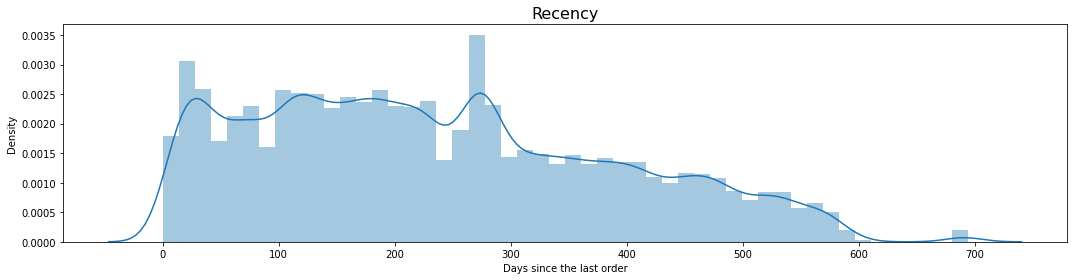

In [11]:
# Plotting Recency
plt.figure(figsize=(18, 4))
sns.distplot(all_data['recency'])

plt.xlabel('Days since the last order')
plt.title('Recency',fontsize=16);
plt.show()

/Users/martina/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


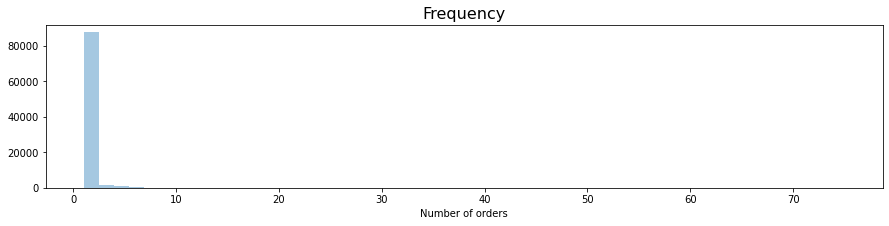

1     77259
2     10073
3      1836
4       853
5       292
6       259
7        67
8        38
12       22
9        20
10       17
11       17
14        8
13        5
15        5
24        4
20        3
21        3
16        2
38        1
18        1
19        1
22        1
26        1
35        1
75        1
Name: frequency, dtype: int64


In [12]:
# Plotting Frequency
plt.figure(figsize=(15, 3))
sns.distplot(all_data['frequency'], kde=False);

plt.xlabel('Number of orders')
plt.title('Frequency',fontsize=16);
plt.show()
print(all_data['frequency'].value_counts())

/Users/martina/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


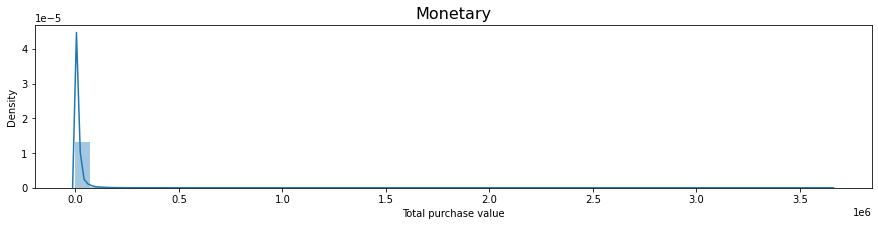

In [13]:
# Plotting Monetary
plt.figure(figsize=(15, 3))
sns.distplot(all_data['transaction_value']);

plt.xlabel('Total purchase value')
plt.title('Monetary', fontsize=16);
plt.show()

In [14]:
# Compute ratings for each product category
rating_count = (df.groupby(by = ['product_category_name'])['review_score'].mean().reset_index().rename(columns = {'review_score':'review_count'})[['product_category_name','review_count']])


In [17]:
# sort products by review, from highest to lowest
product_rew = rating_count.sort_values(by=['review_count'], ascending=False)
best_products = product_rew[:10]
best_products = best_products[['product_category_name','review_count']]
best_products[:10]

,product_category_name,review_count
46,model hobby building,4.714286
16,diet sports nutrition,4.466667
4,bedroom decor,4.462185
67,woman's fashion,4.355556
0,agriculture suppliers,4.313008
38,kids fashion,4.285714
18,event & party supplies,4.266667
45,men's fashion,4.264706
61,underwear,4.215827
7,camera & photo,4.180556


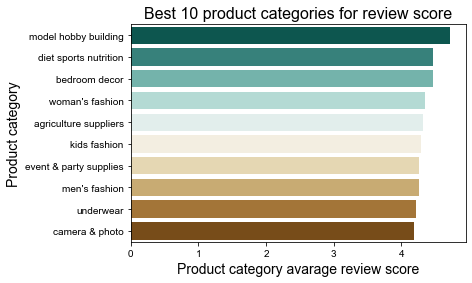

In [18]:
# Plotting the best categories for review score
prodnote_hist = sns.barplot(y = best_products["product_category_name"], x = best_products["review_count"], palette = "BrBG_r");
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(10,8)})
plt.title('Best 10 product categories for review score', fontsize = 16)
plt.xlabel('Product category avarage review score', fontsize = 14)
plt.ylabel('Product category', fontsize = 14)
plt.savefig('best10productreviw.png')

### RFM ANALYSIS


In [19]:
# Select data for RFM analysis
df_RFM = all_data[['customer_unique_id', 'frequency', 'recency', 'transaction_value']]
df_RFM = df_RFM.reset_index(drop=True)
df_RFM.head()

(90790, 4)


,customer_unique_id,frequency,recency,transaction_value
54839,9a736b248f67d166d2fbb006bcb877c3,75,385,12179.0
39723,6fbc7cdadbb522125f4b27ae9dee4060,38,340,38646.0
88623,f9ae226291893fda10af7965268fb7f6,35,535,94647.0
30816,569aa12b73b5f7edeaa6f2a01603e381,26,448,3253.0
77851,db1af3fd6b23ac3873ef02619d548f9c,24,418,61074.0


In [21]:
# computation of quantiles
quintiles = df_RFM[['recency', 'frequency', 'transaction_value']].quantile([.2, .4, .6, .8]).to_dict()

In [22]:
# Defining functions for R score and FM score
def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1
    
def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5   

In [23]:
# Computation of the R, F and M values
df_RFM['R'] = df_RFM['recency'].apply(lambda x: r_score(x))
df_RFM['F'] = df_RFM['frequency'].apply(lambda x: fm_score(x, 'frequency'))
df_RFM['M'] = df_RFM['transaction_value'].apply(lambda x: fm_score(x, 'transaction_value'))
df_RFM['RFM Score'] = df_RFM['R'].map(str) + df_RFM['F'].map(str) + df_RFM['M'].map(str)

### Segments
One time buyers: low recency, low frequency 


About to Sleep: low recency, high frequency: the ones that made some purchases but are not active anymore


Potential Loyalist: high recency, low frequency: new customers who recently made a purchase and might become loyal customers


Loyal Customers: medium recency, high frequency: we eant them to become Champions


Champions: high recency, high frequency; higest score 


Strangers: medium recency, low frequency


In [24]:
# Build a segmentation map
segm1_map = {
    r'[1-2]1': 'One Time',
    r'[1-2][4-5]': 'About to Sleep',
    r'5[1-2]': 'Potential Loyalist',
    r'[3-4]5': 'Loyal Customers',
    r'[4-5]5': 'Champions',
    r'[3-4][1-3]': 'Strangers'
}

df_RFM['Segment1'] = df_RFM['R'].map(str) + df_RFM['F'].map(str)
df_RFM['Segment1'] = df_RFM['Segment1'].replace(segm1_map, regex=True)
all_data['R'] = all_data['recency'].apply(lambda x: r_score(x))
all_data['F'] = all_data['frequency'].apply(lambda x: fm_score(x, 'frequency'))
all_data['M'] = all_data['transaction_value'].apply(lambda x: fm_score(x, 'transaction_value'))
all_data['RFM Score'] = all_data['R'].map(str) + all_data['F'].map(str) + all_data['M'].map(str)
all_data['Segment1'] = all_data['R'].map(str) + all_data['F'].map(str)
all_data['Segment1'] = all_data['Segment1'].replace(segm1_map, regex=True)

### All spenders

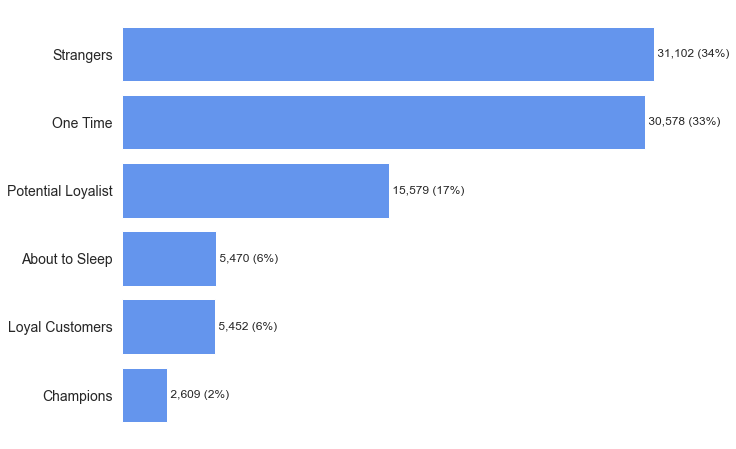

In [119]:
# Segments classified according to how much they spend
segment1s_counts = df_RFM['Segment1'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segment1s_counts)),
              segment1s_counts,
              color='cornflowerblue')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segment1s_counts)))
ax.set_yticklabels(segment1s_counts.index,  fontsize = 14)

for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                ' {:,} ({:}%)'.format(int(value),
                                   int(value*100/segment1s_counts.sum())),
                va='center',
                ha='left'
               )
sns.set(rc={'figure.figsize':(5,10)})
plt.savefig('rfm_segments.png')

### Low spenders

<ipython-input-25-59c93c96d93d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_spenders['Segment_big'] = low_spenders['R'].map(str) + low_spenders['F'].map(str)
<ipython-input-25-59c93c96d93d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_spenders['Segment_big'] = low_spenders['Segment_big'].replace(segm1_map, regex=True)


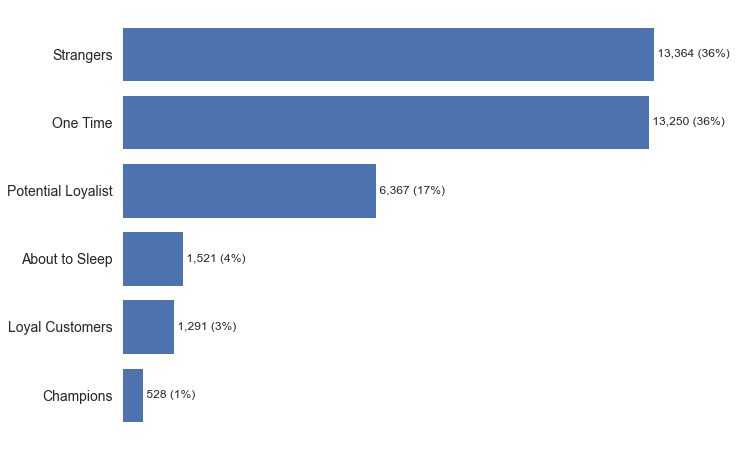

In [25]:
# Plot for low-spending people
low_spenders = df_RFM[df_RFM['M'] <= 2]
low_spenders['Segment_big'] = low_spenders['R'].map(str) + low_spenders['F'].map(str)
low_spenders['Segment_big'] = low_spenders['Segment_big'].replace(segm1_map, regex=True)

segment1s_counts = low_spenders['Segment_big'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segment1s_counts)),
              segment1s_counts,
              color='b')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segment1s_counts)))
ax.set_yticklabels(segment1s_counts.index,  fontsize = 14)

for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                ' {:,} ({:}%)'.format(int(value),
                                   int(value*100/segment1s_counts.sum())),
                va='center',
                ha='left'
               )
sns.set(rc={'figure.figsize':(5,10)})
plt.show()

### Average spenders

<ipython-input-26-37b72d5b3e7d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_spenders['Segment_big'] = avg_spenders['R'].map(str) + avg_spenders['F'].map(str)
<ipython-input-26-37b72d5b3e7d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_spenders['Segment_big'] = avg_spenders['Segment_big'].replace(segm1_map, regex=True)


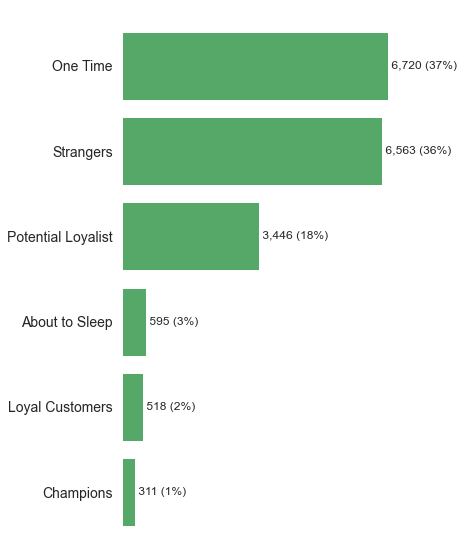

In [26]:
# Plot for average-spending people

avg_spenders = df_RFM[df_RFM['M'] == 3]
avg_spenders['Segment_big'] = avg_spenders['R'].map(str) + avg_spenders['F'].map(str)
avg_spenders['Segment_big'] = avg_spenders['Segment_big'].replace(segm1_map, regex=True)

segment1s_counts = avg_spenders['Segment_big'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segment1s_counts)),
              segment1s_counts,
              color='g')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segment1s_counts)))
ax.set_yticklabels(segment1s_counts.index,  fontsize = 14)

for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                ' {:,} ({:}%)'.format(int(value),
                                   int(value*100/segment1s_counts.sum())),
                va='center',
                ha='left'
               )
sns.set(rc = {'figure.figsize':(5,10)})
plt.show()

### High spenders

36316


<ipython-input-27-a1e00c8abba1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_spenders['Segment_big'] = high_spenders['R'].map(str) + high_spenders['F'].map(str)
<ipython-input-27-a1e00c8abba1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_spenders['Segment_big'] = high_spenders['Segment_big'].replace(segm1_map, regex=True)


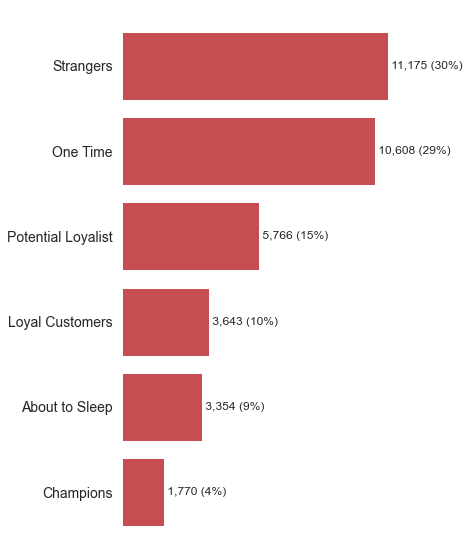

In [27]:
# Plot for high-spending people
high_spenders = df_RFM[df_RFM['M'] >= 4]
print(len(high_spenders))

high_spenders['Segment_big'] = high_spenders['R'].map(str) + high_spenders['F'].map(str)
high_spenders['Segment_big'] = high_spenders['Segment_big'].replace(segm1_map, regex=True)

segment1s_counts = high_spenders['Segment_big'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segment1s_counts)),
              segment1s_counts,
              color = 'r')
ax.set_frame_on(False)
ax.tick_params(left = False,
               bottom = False,
               labelbottom = False)
ax.set_yticks(range(len(segment1s_counts)))
ax.set_yticklabels(segment1s_counts.index,  fontsize = 14)

for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                ' {:,} ({:}%)'.format(int(value),
                                   int(value*100/segment1s_counts.sum())),
                va = 'center',
                ha = 'left'
               )
sns.set(rc = {'figure.figsize':(5,10)})
plt.show()

### Values for each Segment

In [28]:
# Group customers by segments
df_rfm2 = df_RFM.groupby('Segment1').agg(RecencyMean = ('recency', 'mean'),
                                          FrequencyMean = ('frequency', 'mean'),
                                          MonetaryMean = ('transaction_value', 'mean'),
                                          GroupSize = ('recency', 'size'))


NameError: name 'squarify' is not defined

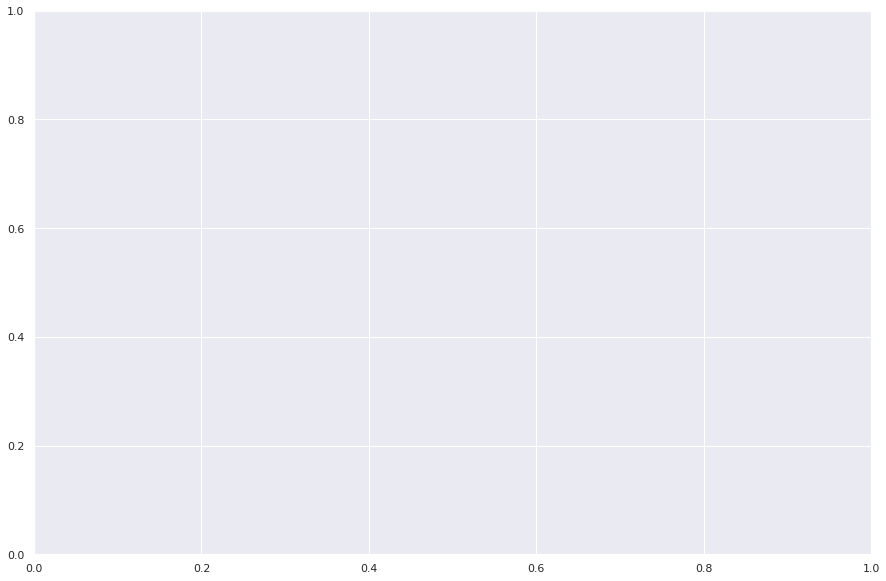

In [30]:
# Plot of segments size
font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)


fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(15, 10)
squarify.plot(sizes = df_rfm2['GroupSize'], 
              label = df_rfm2.index,
              color = ['blue','firebrick', 'tomato', 'teal', 'olive', 'gold'],
              alpha = 0.5)
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.savefig('rfm_square.png')

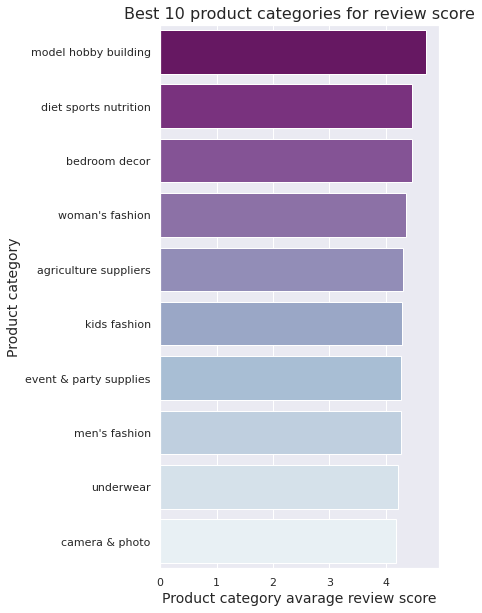

In [31]:
# Best 10 products for review score
prodnote_hist = sns.barplot( y=best_products["product_category_name"], x=best_products["review_count"],palette = "BuPu_r");
sns.set_context("talk")
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(10,8)})
plt.title('Best 10 product categories for review score', fontsize = 16)
plt.xlabel('Product category avarage review score', fontsize = 14)
plt.ylabel('Product category', fontsize = 14)
plt.savefig('best10product per review.png')

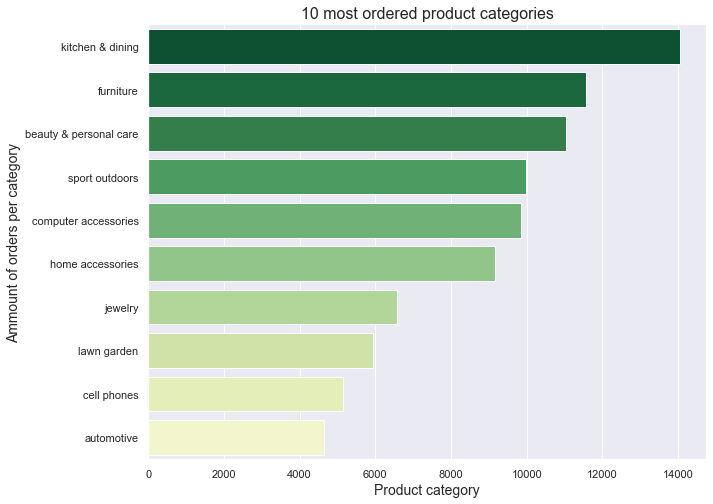

In [32]:
# 10 mosr ordered product categories
prodcat = df.groupby(['product_category_name']).sum().reset_index() 
prodcat = prodcat[prodcat['product_category_name'] != 'None']
prodcat = prodcat.sort_values(by=['order_item_sequence_id'], ascending=False)
prodcat0 = prodcat[:10]
sns.set_context("talk")
sns.set_style("white")
sns.set(rc={'figure.figsize':(10,8)})
catorderhist = sns.barplot( y=prodcat0["product_category_name"], x=prodcat0["order_item_sequence_id"] ,palette = 'YlGn_r');
plt.title('10 most ordered product categories', fontsize = 16)
plt.xlabel('Product category', fontsize = 14)
plt.ylabel('Ammount of orders per category', fontsize = 14)
plt.savefig('10 most ordered product categories.png' )

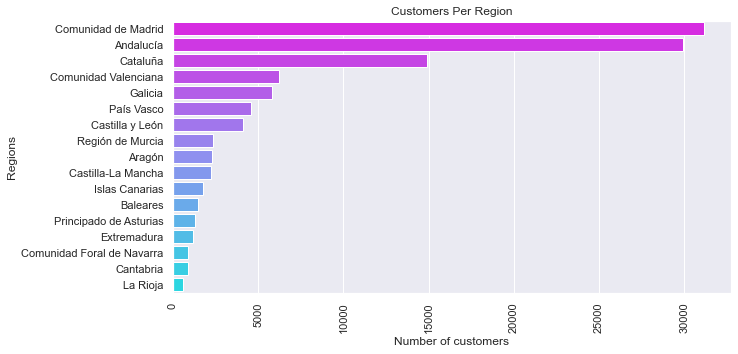

In [33]:
# Number of customers by region
plt.figure(figsize = (10,5))
plt.title('Customers Per Region')
plt.ylabel('Regions')
plt.xlabel('Number of customers')
sns.barplot(y = df['customer_autonomous_community'].value_counts().index,
            x = df['customer_autonomous_community'].value_counts().values, palette = 'cool_r')
plt.xticks(rotation = 90)
plt.savefig('customers per region.png')

### Time Data Managing

In [34]:
# We will work only with the orders with status == delivered
data__orders=df.loc[df['order_status'] == 'delivered']
data__orders['ts_order_purchase'] = pd.to_datetime(data__orders['ts_order_purchase'])
data__orders['ts_order_estimated_delivery'] = pd.to_datetime(data__orders['ts_order_estimated_delivery'])
data__orders['ts_order_delivered_customer'] = pd.to_datetime(data__orders['ts_order_delivered_customer'])
data__orders['dif_exp_delivery'] = ((data__orders['ts_order_estimated_delivery'])-(data__orders['ts_order_delivered_customer'])).dt.days
data__orders['dif_exp_delivery'].fillna(0,inplace=True)
data__orders.dropna(inplace = True)
data__orders['dif_exp_delivery'] = data__orders['dif_exp_delivery'].astype('int64')

<ipython-input-34-98854bd19a97>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data__orders['ts_order_purchase'] = pd.to_datetime(data__orders['ts_order_purchase'])
<ipython-input-34-98854bd19a97>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data__orders['ts_order_estimated_delivery'] = pd.to_datetime(data__orders['ts_order_estimated_delivery'])
<ipython-input-34-98854bd19a97>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [35]:
# New Columns to add to the dataset
data__orders['year_purch'] = data__orders['ts_order_purchase'].dt.year
data__orders['month_purch'] = data__orders['ts_order_purchase'].dt.month
data__orders['day_purch'] = data__orders['ts_order_purchase'].dt.day
data__orders['week_day'] = data__orders['ts_order_purchase'].dt.weekday

<ipython-input-35-0c4c3fff7822>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data__orders['year_purch'] = data__orders['ts_order_purchase'].dt.year
<ipython-input-35-0c4c3fff7822>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data__orders['month_purch'] = data__orders['ts_order_purchase'].dt.month
<ipython-input-35-0c4c3fff7822>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [37]:
# Assign a number for each day of the week
day_name = []
for d in data__orders.week_day:
    if d == 6:
        d = 'Sun'
    elif d == 0:
        d = 'Mon'
    elif d == 1:
        d = 'Tue'
    elif d == 2:
        d = 'Wed'
    elif d == 3:
        d = 'Thur'
    elif d == 4:
        d = 'Fri'
    else:
        d = 'Sat'
    day_name.append(d)
data__orders['week_day'] = day_name

<ipython-input-37-3d7ecb1fe701>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data__orders['week_day'] = day_name


In [38]:
# Convert to datetime and compute difference between estimate and actual delivery
data__orders['ts_order_purchase'] = pd.to_datetime(data__orders['ts_order_purchase'])
data__orders['ts_order_estimated_delivery'] = pd.to_datetime(data__orders['ts_order_estimated_delivery'])
data__orders['ts_order_delivered_customer'] = pd.to_datetime(data__orders['ts_order_delivered_customer'])
data__orders['dif_exp_delivery']=((data__orders['ts_order_estimated_delivery'])-(data__orders['ts_order_delivered_customer'])).dt.days

<ipython-input-38-311525127809>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data__orders['ts_order_purchase'] = pd.to_datetime(data__orders['ts_order_purchase'])
<ipython-input-38-311525127809>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data__orders['ts_order_estimated_delivery'] = pd.to_datetime(data__orders['ts_order_estimated_delivery'])
<ipython-input-38-311525127809>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [42]:
# Time data modifications
data__orders['ts_order_purchase'] = pd.to_datetime(data__orders['ts_order_purchase'])
data__orders['ts_order_purchase'] = data__orders['ts_order_purchase'].dt.date
data__orders['hour_purch'] = data__orders['ts_order_purchase'].dt.round('360min')
data__orders['hour_purch'] = pd.to_datetime(data__orders['hour_purch'])
data__orders['hour_purch'] = data__orders['hour_purch'].dt.time
data__orders['hour_purch'] = data__orders['ts_order_purchase'].dt.round('360min')
data__orders['month_year_purch'] = data__orders['ts_order_purchase'].dt.strftime('%m-%Y')
data__orders.drop(['ts_order_purchase'],axis = 1, inplace=True)

<ipython-input-42-4995d2d656b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data__orders['ts_order_purchase'] = pd.to_datetime(data__orders['ts_order_purchase'])
<ipython-input-42-4995d2d656b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data__orders['ts_order_purchase'] = data__orders['ts_order_purchase'].dt.date


AttributeError: Can only use .dt accessor with datetimelike values

In [100]:
#Drop some data we will not use
"""data__orders.drop(['ts_order_approved'],axis=1,inplace=True)
data__orders.drop(['ts_order_delivered_carrier'],axis=1,inplace=True)
data__orders.drop(['ts_order_delivered_customer'],axis=1,inplace=True)
data__orders.drop(['ts_order_estimated_delivery'],axis=1,inplace=True)
df.drop(['product_name_lenght'],axis=1,inplace=True)
df.drop(['product_photos_quantity'],axis=1,inplace=True)
df.drop(['product_description_lenght'],axis=1,inplace=True)
df.drop(['product_weight_gr'],axis=1,inplace=True)
df.drop(['product_length_cm'],axis=1,inplace=True)
df.drop(['product_height_cm'],axis=1,inplace=True)
df.drop(['product_width_cm'],axis=1,inplace=True)"""

"data__orders.drop(['ts_order_approved'],axis=1,inplace=True)\ndata__orders.drop(['ts_order_delivered_carrier'],axis=1,inplace=True)\ndata__orders.drop(['ts_order_delivered_customer'],axis=1,inplace=True)\ndata__orders.drop(['ts_order_estimated_delivery'],axis=1,inplace=True)\ndf.drop(['product_name_lenght'],axis=1,inplace=True)\ndf.drop(['product_photos_quantity'],axis=1,inplace=True)\ndf.drop(['product_description_lenght'],axis=1,inplace=True)\ndf.drop(['product_weight_gr'],axis=1,inplace=True)\ndf.drop(['product_length_cm'],axis=1,inplace=True)\ndf.drop(['product_height_cm'],axis=1,inplace=True)\ndf.drop(['product_width_cm'],axis=1,inplace=True)"

In [107]:
# Data without the dropped columns
filtro  = data__orders['month_purch'].isin([1,2,3,4,5,6,7,8])
data_aux= data__orders[filtro]


,order_id,order_item_sequence_id,product_id,price,shipping_cost,seller_id,max_shipping_seller_date,review_score,review_date,seller_autonomous_community,...,customer_unique_id,customer_autonomous_community,customer_city,dif_exp_delivery,year_purch,month_purch,day_purch,week_day,hour_purch,month_year_purch
820,ec7a019261fce44180373d45b442d78f,1,f5d8f4fbc70ca2a0038b9a0010ed5cb0,109,872,48efc9d94a9834137efd9ea76b065a38,2018-01-09 11:56:00,5.0,2018-01-13 20:22:00,Galicia,...,f7b981e8a280e455ac3cbe0d5d171bd1,Galicia,Coruña,20,2018,1,5,4,2018-01-05,01-2018
821,b95a0a8bd30aece4e94e81f0591249d8,1,6c04a068e5ab37749c980c42a036b9e3,109,872,48efc9d94a9834137efd9ea76b065a38,2018-01-09 12:01:00,5.0,2018-01-18 10:56:00,Galicia,...,83e7958a94bd7f74a9414d8782f87628,Galicia,Coruña,26,2018,1,5,4,2018-01-05,01-2018
822,38bcb524e1c38c2c1b60600a80fc8999,1,680cc8535be7cc69544238c1d6a83fe8,29,872,48efc9d94a9834137efd9ea76b065a38,2018-01-09 12:06:00,1.0,2018-01-18 11:51:00,Galicia,...,728e4a7d0db4845270091ded0923c71f,Galicia,Coruña,27,2018,1,5,4,2018-01-05,01-2018
823,7a18a504c1a4b32d883e68de2e1a7db0,1,c0d4027067afcf9c1697cce981b8fed6,79,872,48efc9d94a9834137efd9ea76b065a38,2018-01-09 12:09:00,3.0,2018-01-18 11:54:00,Galicia,...,728e4a7d0db4845270091ded0923c71f,Galicia,Coruña,27,2018,1,5,4,2018-01-05,01-2018
824,6acecf438369055d9243e121045cca74,1,1514ddb0f4a5afc8d24104e89c714403,99,872,48efc9d94a9834137efd9ea76b065a38,2018-01-09 12:11:00,5.0,2018-01-20 10:01:00,Galicia,...,728e4a7d0db4845270091ded0923c71f,Galicia,Coruña,26,2018,1,5,4,2018-01-05,01-2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118137,1afe384f199748cff7a42c9902065560,1,4c2a4020fcd651812100ebbeac1b2753,59999,2918,610f72e407cdd7caaa2f8167b0163fd8,2019-09-14 02:09:00,5.0,2019-08-26 16:30:00,Comunidad de Madrid,...,24a438c52577c3c30ba86532b4166ff8,Andalucía,Málaga,26,2019,8,21,2,2019-08-21,08-2019
118138,7cfdf7265c9572fc7b7cbd3b9cc438b7,2,17e18b0c88a853dd6de3e48a7cfa9d9a,20,1925,cee48807215b30a12ca2ca10ffb5f250,2019-09-14 12:30:00,1.0,2019-08-29 14:16:00,Andalucía,...,56b6eede1b10925212f054a7ba614796,Comunidad de Madrid,Alcorcón,35,2019,8,21,2,2019-08-21,08-2019
118139,3b61aab5de69abc1731138bd104a777f,1,6aa063e063f2ab982b471e58afe06d72,99999,2477,610f72e407cdd7caaa2f8167b0163fd8,2019-09-18 21:10:00,2.0,2019-09-02 22:51:00,Comunidad de Madrid,...,101375bf617fd60c9eee42f98d9a73d6,Comunidad de Madrid,Madrid,21,2019,8,25,6,2019-08-25,08-2019
118142,c2bb89b5c1dd978d507284be78a04cb2,1,87b92e06b320e803d334ac23966c80b1,9999,6144,7a241947449cc45dbfda4f9d0798d9d0,2020-04-09 22:35:00,1.0,2018-06-12 13:24:00,Comunidad de Madrid,...,44b6bbfea26596437062a38c8e6bcec1,Andalucía,Huelva,123,2018,5,23,2,2018-05-23,05-2018


In [53]:
data__orders.to_csv('data__orders.csv')

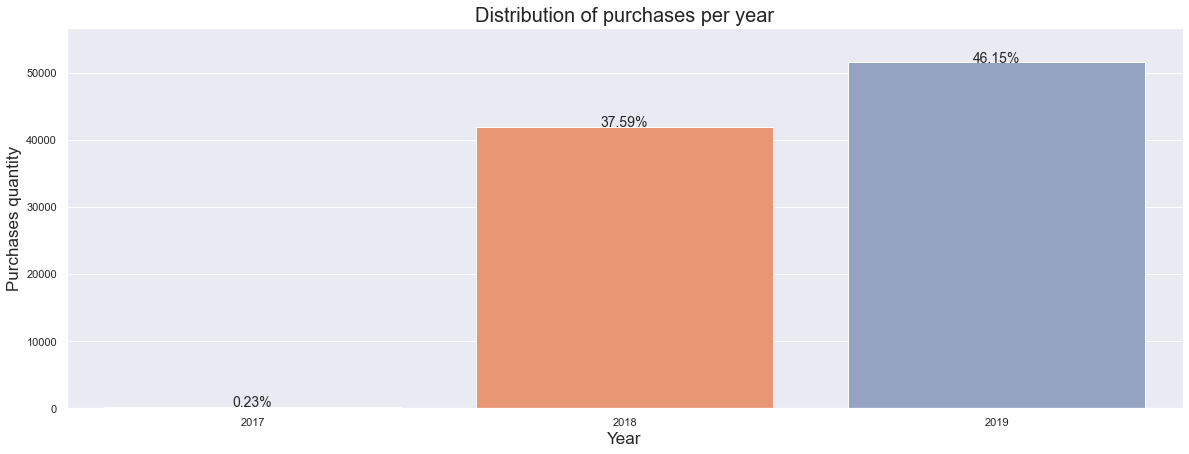

In [43]:
# Distribution of purchases per year
plt.figure(figsize=(20,7))
plt.subplot(111)
year_seasonality = data__orders.groupby(['year_purch'])['order_id'].nunique().sort_values(ascending=True).reset_index()
total=len(data__orders)
g = sns.barplot(x='year_purch', y='order_id', data=year_seasonality, palette='Set2')
g.set_title("Distribution of purchases per year", fontsize=20)
g.set_xlabel("Year", fontsize=17)
g.set_ylabel("Purchases quantity", fontsize=17)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.1)
plt.savefig('distribution purchases per year.png')

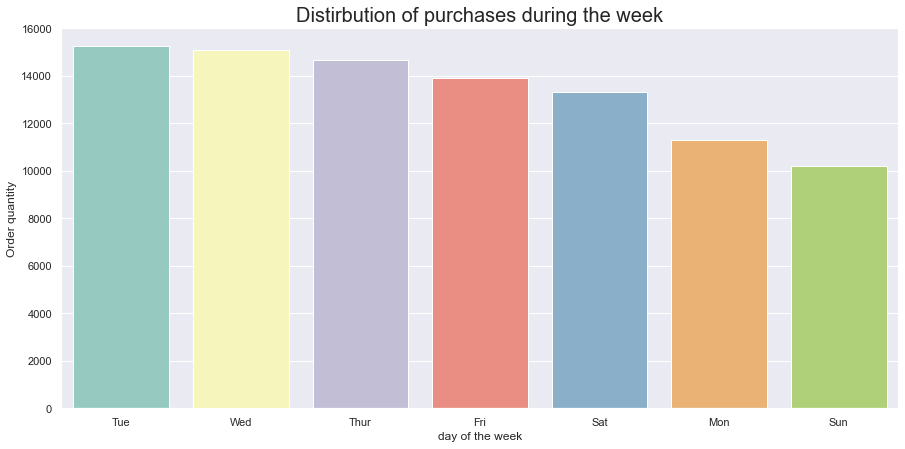

In [44]:
# Distribution of purchases during the week
plt.figure(figsize=(15,7))
weekle_seasonality = data__orders.groupby(['week_day'])['order_id'].nunique().sort_values(ascending=False).reset_index()
sns.barplot(x='week_day',y='order_id', data=weekle_seasonality, palette = 'Set3')
plt.title("Distirbution of purchases during the week", fontsize=20)
plt.xlabel('day of the week')
plt.ylabel('Order quantity')
plt.savefig('distr purchases during week.png')